# ***Predictive Healthcare: Machine Learning for Disease Prediction(Diabetes)***

**DATA SOURCE:** [KAGGLE DATASET](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset )

# **Reference: Tutorials, Chatgpt, Kaggle**

#                                **Objective:**
**The objective of this dataset is to build a predictive model for diagnosing diabetes in patients.The model should predict whether a patient has diabetes (Outcome = 1) or does not have diabetes (Outcome = 0) based on several diagnostic measurements, including glucose level, blood pressure, hypertension, heart diseases, BMI, and age etc..**

# **Initial Setup**
**Import the necessary libraries and load the datasets**.

In the code block below , I imported essential libraries:
Pandas and NumPy for data manipulation.
Matplotlib and Seaborn for visualization, with a clean style applied for better
presentation.

In [ ]:
import pandas as pd        # For loading, manipulating, and exploring datasets
import numpy as np         # For numerical computations
import seaborn as sns      # For plotting graphs like count plots and heatmaps
import matplotlib.pyplot as plt      # For generating visualizations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder   # standard scaler for feature scaling and LabelEncoder() for encoding categorical variables
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap       # to know how each feature contributes to the model's predictions to making the model more transparent and interpretable
from imblearn.over_sampling import SMOTE    # to balance the data (oversampling)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter

In [ ]:
!pip install XGBoost

In [ ]:
# Load datasets:
# here i am  Reading the datasets into pandas DataFrames to perform suitable operations on data
diabetes_df = pd.read_csv("diabetes_prediction_dataset.csv")
print(diabetes_df["diabetes"].value_counts())  # this shows how many peoples are having diabetes and how many doesn't.
# 0:Negative diabetes      1:positive diabetes

# Displaying the first few rows of the training dataset to understand its struct
print("First few rows of the training dataset:")
print(diabetes_df.head())


diabetes
0    91500
1     8500
Name: count, dtype: int64
First few rows of the training dataset:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


# **Peoples who are not suffering from diabetes are very large as compared to others who are suffering. This shows real data**

In [ ]:
# Identify target column dynamically
# if any column name matches any name in possible_names, that column is our target. we use this to find target variable without manually mentioning it
def find_target_column(df, possible_names):
    for col in df.columns:                   # Iterate through all column names in the DataFrame
        if col.lower() in possible_names:    # Convert column name to lowercase and check if it's in the given set
            return col                       # If a match is found, return that column name
    raise ValueError(f"No suitable target column found in dataset: {df.columns}")

# Assign target column names dynamically based on dataset structure
target_col_diabetes = find_target_column(diabetes_df, {"outcome", "label", "diabetes"})

# **Label Encoding**: My dataset contains some categorial data but Machine learning models, especially those based on numerical computations, cannot process categorical so we use encoder to convert categorial data into numerical data


In [ ]:
# Encode categorical variables
# to convert categorical features into numerical form for model processing
def encode_categorical(df):
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, label_encoders

diabetes_df, _ = encode_categorical(diabetes_df)

# **Exploratory Data Analysis (EDA)**
In this section, I will perform a detailed exploratory data analysis (EDA) to understand the
dataset's structure, features, and quality. This includes:
1. Dataset size and dimensions.
2. Types of features.
3. Statistics of features.
4. Data health assessment.
5. Handling missing data.


In [ ]:
# Remove duplicate records to avoid data processing repeatedly
diabetes_df = diabetes_df.drop_duplicates()

# **Dataset Size and Dimensions**

In [ ]:
# Dataset Information--> rows, columns in each dataset with feature types
def dataset_info(df, name):
    print(f"Dataset: {name}\n")
    print("Number of Rows:", df.shape[0])
    print("Number of Columns:", df.shape[1])
    print("Feature types:")
    print(df.dtypes, "\n")

dataset_info(diabetes_df, "Diabetes Prediction Dataset")

Dataset: Diabetes Prediction Dataset

Number of Rows: 96146
Number of Columns: 9
Feature types:
gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object 



# **Rows** contains Patients while **Columns** contains features
 **Types of Features**

I this section we examine the types of features in the dataset.


**It provides summary statistics for numerical features**

**including: Mean → Average value of each feature.**

**Standard Deviation → Spread of the data.**


In [ ]:
# Statistics of Features
# give summary statistics of numerical and categorical features like mean,standard deviation etc.
def feature_statistics(df, name):
    print(f"Statistics for {name}\n")
    print("Numerical Features:")
    print(df.describe(), "\n")

    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print("Categorical Features:")
        print(df[categorical_cols].describe(), "\n")
    else:
        print("No categorical features found after encoding.\n")

feature_statistics(diabetes_df, "Diabetes Prediction Dataset")

Statistics for Diabetes Prediction Dataset

Numerical Features:
             gender           age  hypertension  heart_disease  \
count  96146.000000  96146.000000  96146.000000   96146.000000   
mean       0.416065     41.794326      0.077601       0.040803   
std        0.493287     22.462948      0.267544       0.197833   
min        0.000000      0.080000      0.000000       0.000000   
25%        0.000000     24.000000      0.000000       0.000000   
50%        0.000000     43.000000      0.000000       0.000000   
75%        1.000000     59.000000      0.000000       0.000000   
max        2.000000     80.000000      1.000000       1.000000   

       smoking_history           bmi   HbA1c_level  blood_glucose_level  \
count     96146.000000  96146.000000  96146.000000         96146.000000   
mean          2.231159     27.321461      5.532609           138.218231   
std           1.879963      6.767716      1.073232            40.909771   
min           0.000000     10.010000     

# **Good things about the data**
The dataset does not contain missing vlues.

Includes medically relevant attributes like BMI, Blood Glucose, HbA1c Level, and Smoking History, which are crucial for predicting diabetes.

The dataset has a reasonable number of samples, allowing the model to generalize well.


In [ ]:
# Remove Unneccessary value [0.00195%] to simplify data
diabetes_df = diabetes_df[diabetes_df['gender'] != 'Other']

In [ ]:
for column in diabetes_df.columns:                     # to know distinct values in each column
    num_distinct_values = len(diabetes_df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


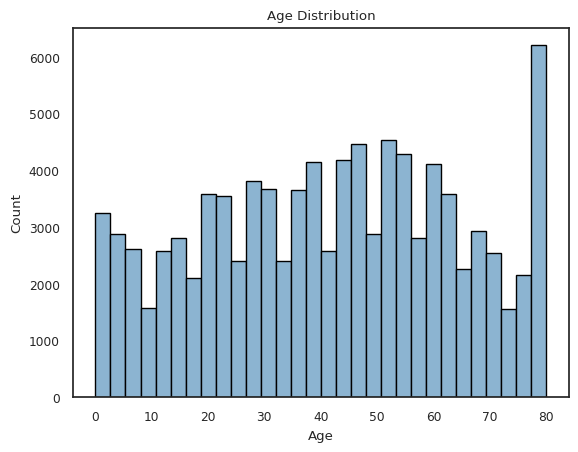

In [ ]:
# Visualizing Age Distribution
plt.hist(diabetes_df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# **# Helps understand the age demographics in the dataset, Identifies whether the dataset is biased toward a specific age group.**

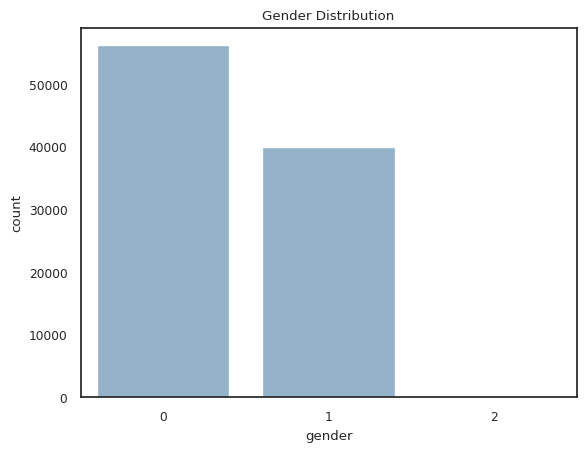

In [ ]:
# Visualizing Gender Distribution
sns.countplot(x='gender', data=diabetes_df)
plt.title('Gender Distribution')
plt.show()

# **# Shows the male-to-female ratio in the dataset.Helps in assessing whether the dataset is balanced across genders.**

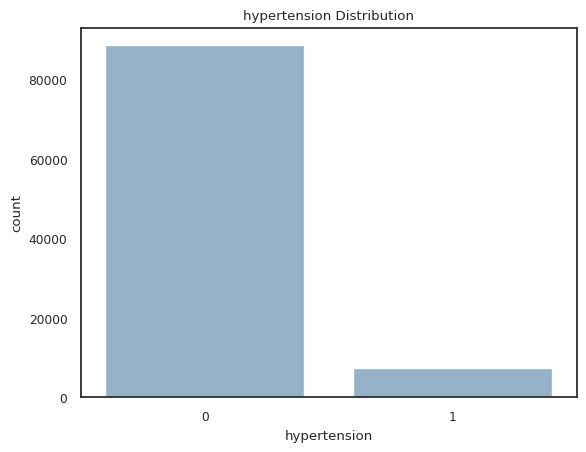

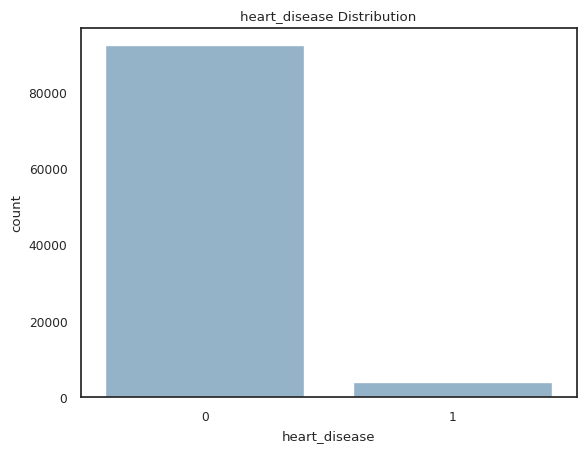

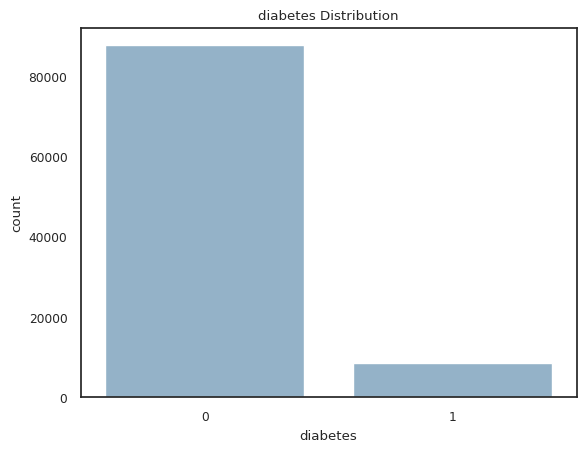

In [ ]:
# Count plots for binary variables for diabetes
for col in ['hypertension', 'heart_disease', 'diabetes']:
  sns.countplot(x=col, data=diabetes_df)
  plt.title(f'{col} Distribution')
  plt.show()

# **# Visualizes the proportion of patients with and without these conditions.Identifies class imbalance in disease presence, which is crucial for model training.**

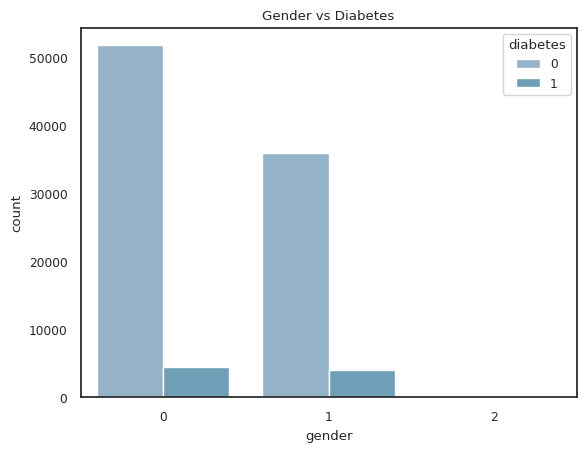

In [ ]:
# Count plot of gender vs diabetes
sns.countplot(x='gender', hue='diabetes', data=diabetes_df)
plt.title('Gender vs Diabetes')
plt.show()

# **Checks if diabetes prevalence differs by gender.**

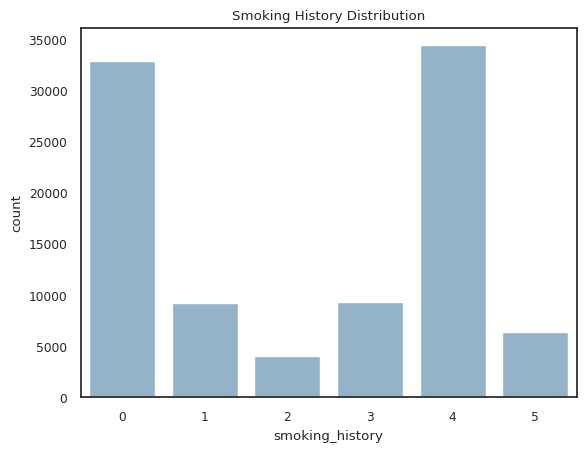

In [ ]:
# Count plot for smoking history for diabetes
sns.countplot(x='smoking_history', data=diabetes_df)
plt.title('Smoking History Distribution')
plt.show()

# **Helps determine if smoking increases diabetes risk. Visualizes the proportion of smokers vs. non-smokers in diabetic and non-diabetic groups.**

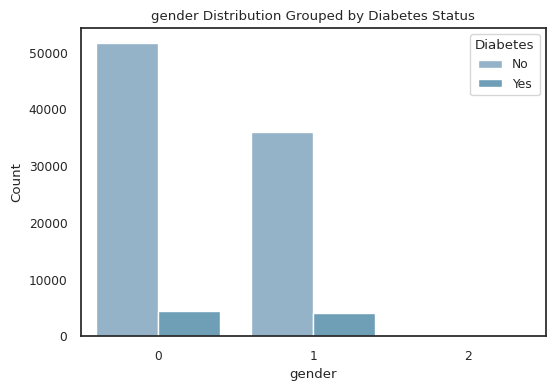

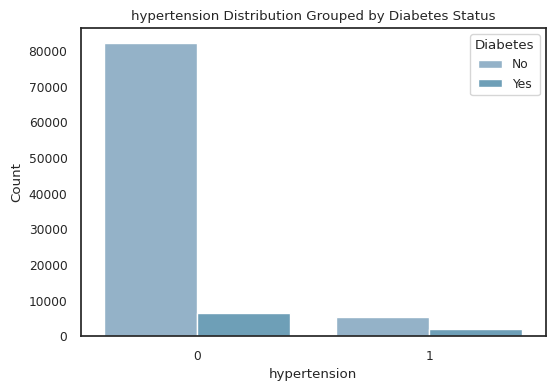

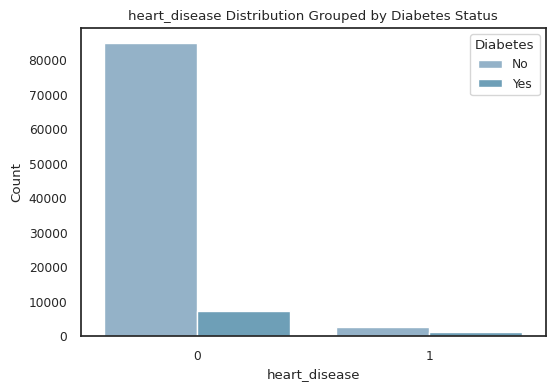

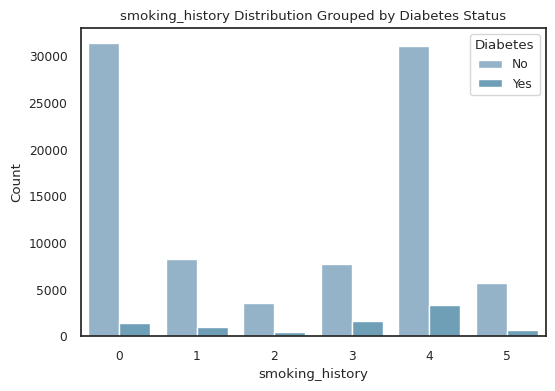

In [ ]:
# Bar plots for categorical features grouped by Diabetes status
categorical_features = ["gender", "hypertension", "heart_disease", "smoking_history"]
for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=diabetes_df[col], hue=diabetes_df["diabetes"])
    plt.title(f"{col} Distribution Grouped by Diabetes Status")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Diabetes", labels=["No", "Yes"])
    plt.show()

### ***Helps in analyzing how different categorical features (e.g., gender, smoking history) are distributed across diabetic and non-diabetic patients. ***
# **If smoking history shows a strong correlation with diabetes, we can retain it as an important feature in the model**

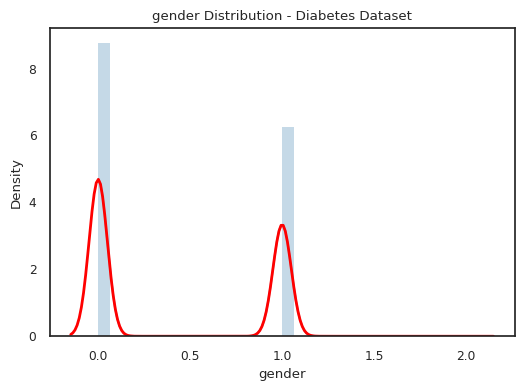

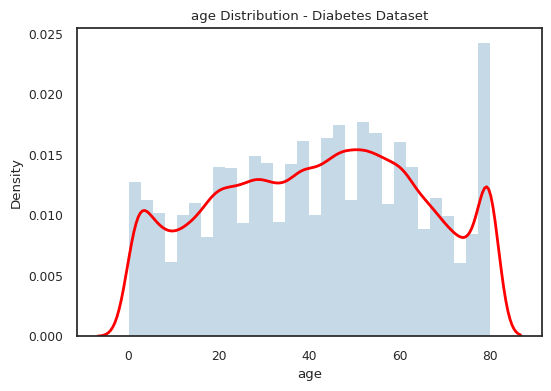

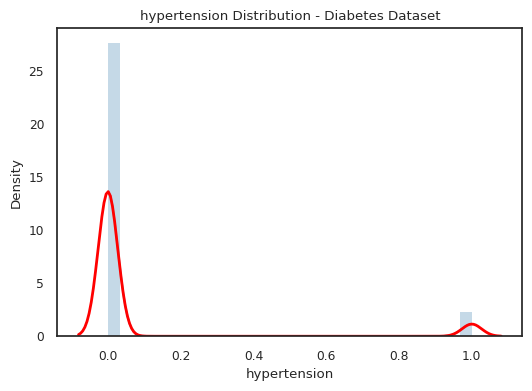

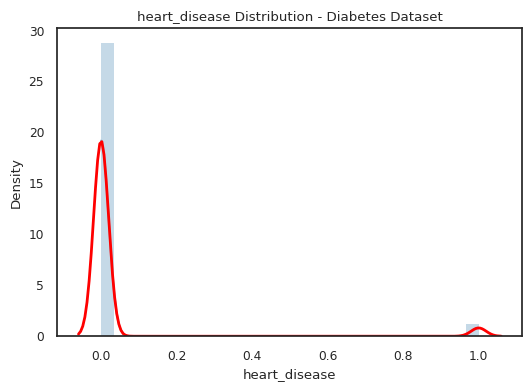

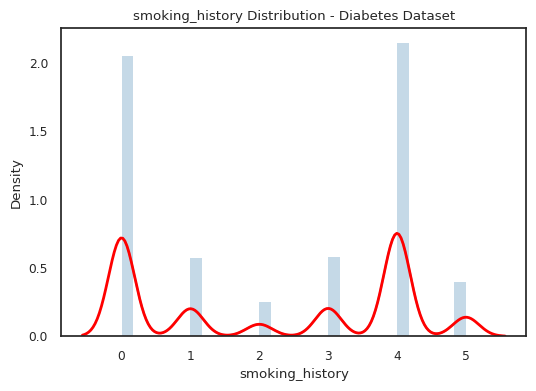

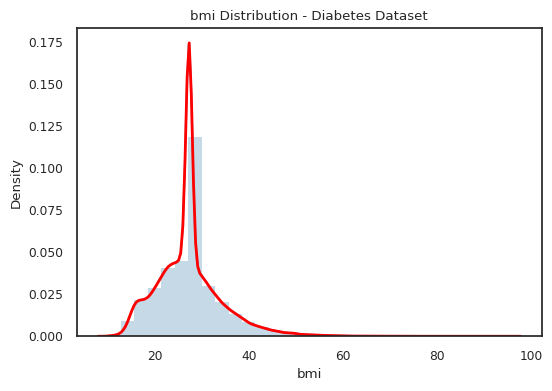

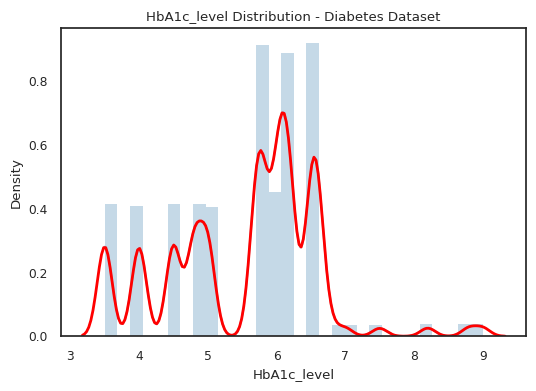

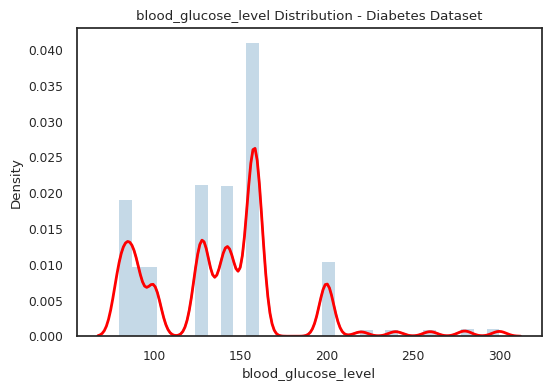

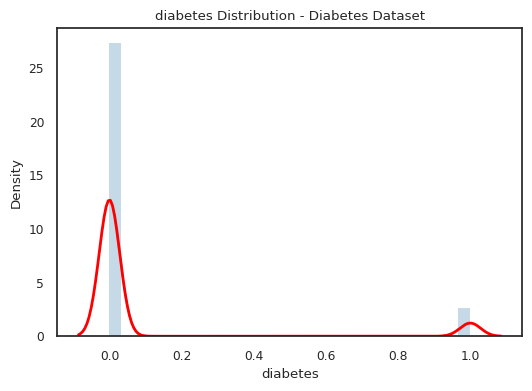

In [ ]:
# Distribution Plots for All Numerical Variables
# Visualizing probability density with histogram and KDE curve
numerical_features_diabetes = diabetes_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in numerical_features_diabetes:
    plt.figure(figsize=(6, 4))
    sns.histplot(diabetes_df[col], bins=30, kde=True, stat="density", linewidth=0)
    sns.kdeplot(diabetes_df[col], color='red', linewidth=2)  # Add KDE curve manually
    plt.title(f"{col} Distribution - Diabetes Dataset")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

# **Helps visualize the spread of numerical features like BMI, blood glucose level, and HbA1c level, Detects skewness or outliers, which may require transformations (e.g., log-scaling) before model training**.**If features have high skewness, log transformation or scaling can improve model performance.**

# **Skewness measures how asymmetrical a dataset is compared to a normal distribution. It tells us whether data values are concentrated more on one side of the mean.**


### **Skewness Theory**
Skewness measures the **asymmetry** of a probability distribution.

The formula for **skewness** is:

\[
Skewness = \frac{n}{(n-1)(n-2)} \sum \left(\frac{X_i - \bar{X}}{\sigma}\right)^3
\]

where:
- \( X_i \) = individual data points
- \( \bar{X} \) = mean of the data
- \( \sigma \) = standard deviation
- \( n \) = number of observations

- **Positive Skewness** → Right-skewed (long right tail)
- **Negative Skewness** → Left-skewed (long left tail)
- **Zero Skewness** → Symmetric distribution


In [ ]:
def calculate_skewness(df, name):
    print(f"Skewness of Numerical Features in {name}:\n")
    skewness = df.skew()
    print(skewness, "\n")

    # Visualizing skewness using histograms
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f"Skewness of {col} - {name} (Skewness: {skewness[col]:.2f})")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

Skewness of Numerical Features in Diabetes Prediction Dataset:

gender                 0.345257
age                   -0.062445
hypertension           3.157676
heart_disease          4.642359
smoking_history       -0.082550
bmi                    1.023751
HbA1c_level           -0.054463
blood_glucose_level    0.836489
diabetes               2.903845
dtype: float64 



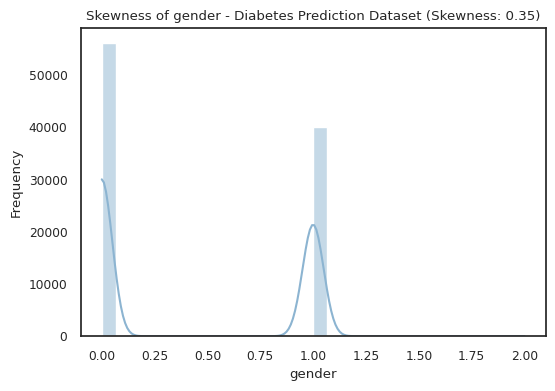

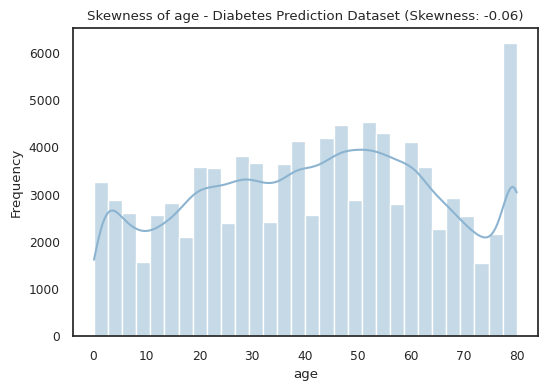

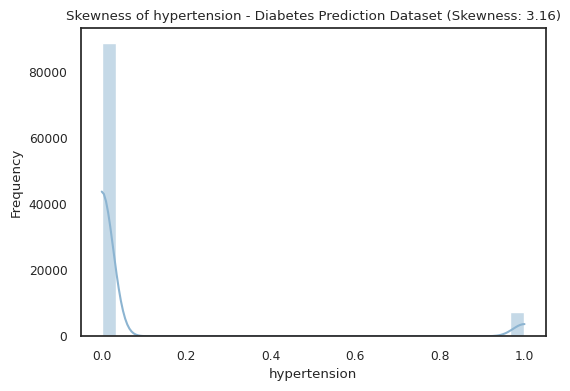

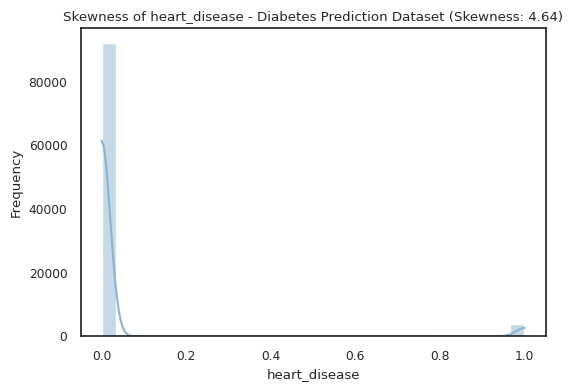

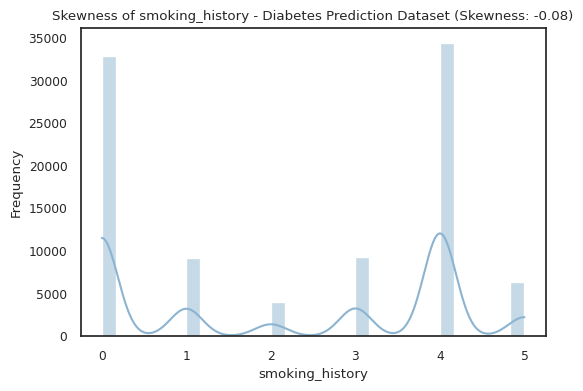

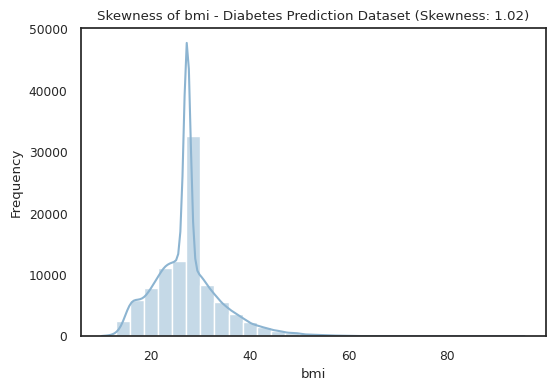

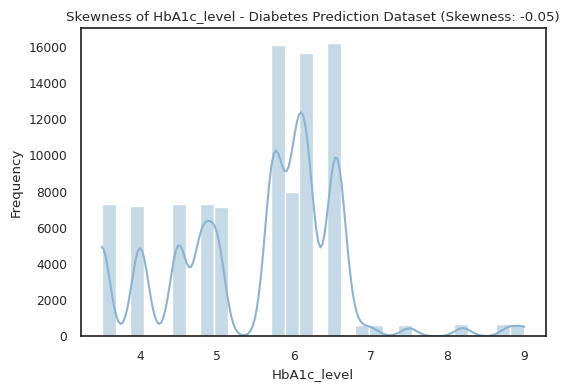

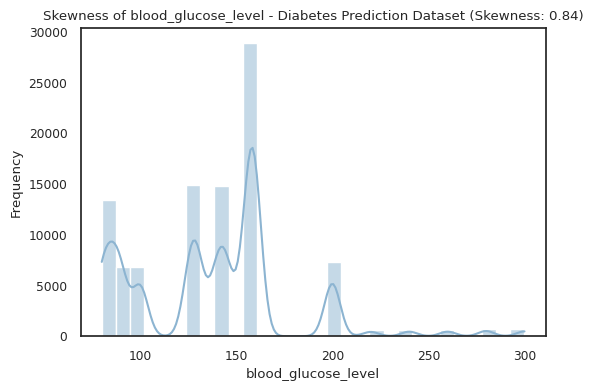

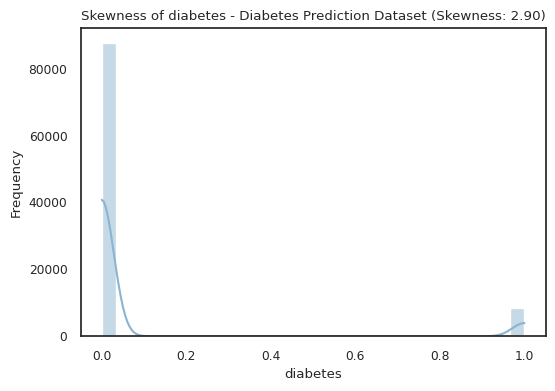

In [ ]:
# Calculate skewness for both datasets
calculate_skewness(diabetes_df, "Diabetes Prediction Dataset")

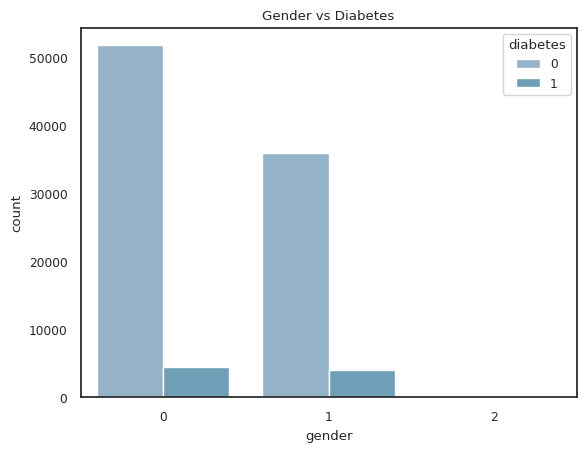

In [ ]:
# Count plot of gender vs diabetes
sns.countplot(x='gender', hue='diabetes', data=diabetes_df)
plt.title('Gender vs Diabetes')
plt.show()

## **# Helps determine if gender is a significant factor in diabetes prevalence.**
# **# If diabetes cases are significantly higher in one gender, gender can be an important feature in the prediction model.**

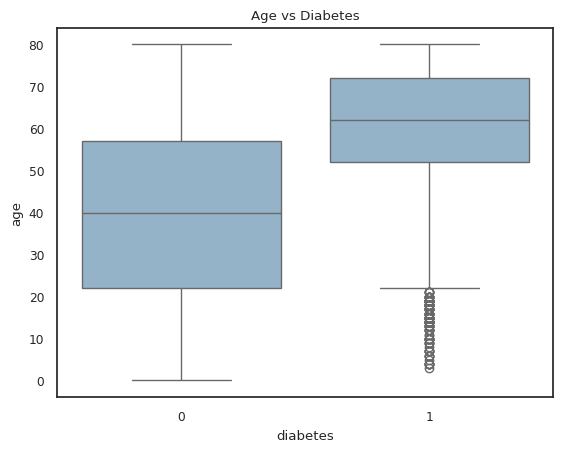

In [ ]:
# Boxplot Age vs Diabetes classification
sns.boxplot(x='diabetes', y='age', data=diabetes_df)
plt.title('Age vs Diabetes')
plt.show()

# **Helps understand how age impacts diabetes prevalence.If older age groups have a higher median diabetes rate, age becomes a strong predictor.**

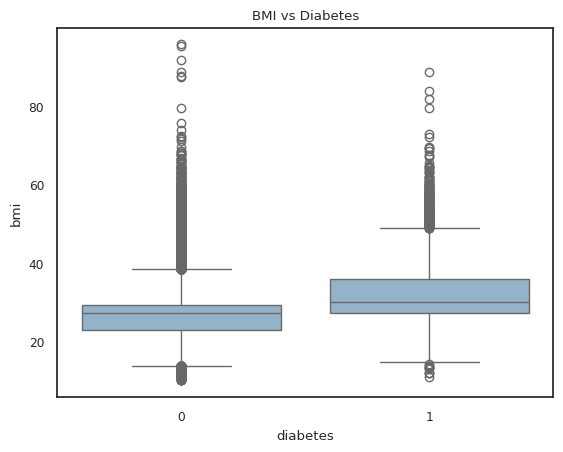

In [ ]:
# Boxplot BMI vs Diabetes classification
sns.boxplot(x='diabetes', y='bmi', data=diabetes_df)
plt.title('BMI vs Diabetes')
plt.show()

# **Checks if higher BMI is linked to diabetes.If higher BMI consistently aligns with diabetes, it’s an important predictor.**

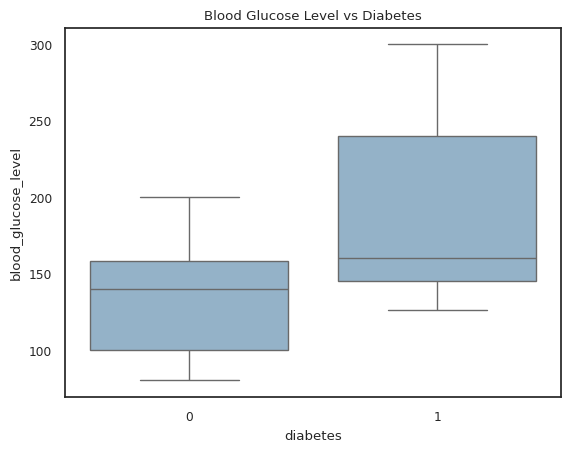

In [ ]:
# Boxplot blood glucose level vs Diabetes classification
sns.boxplot(x='diabetes', y='blood_glucose_level', data=diabetes_df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

**# For diabetes = 0 (no diabetes):**

**# The median blood glucose is around 135.**

**# For diabetes = 1 (diabetes present):**

**# The median is higher, around 160.**

**This shows that people with diabetes tend to have higher blood glucose levels than those without.**

# **Blood glucose is directly related to diabetes diagnosis.If non-diabetic and diabetic patients have overlapping glucose levels, a threshold-based rule might be necessary.**

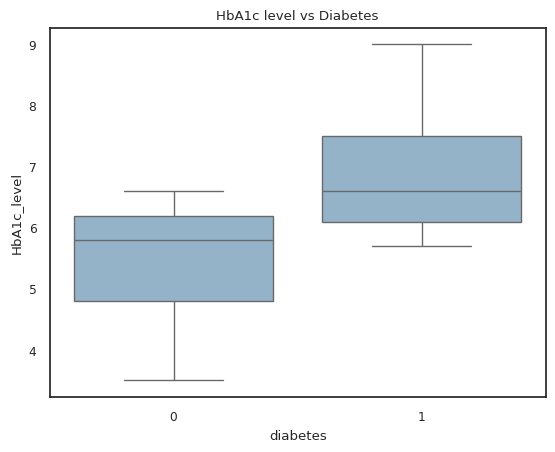

In [ ]:
# Boxplot HbA1c level vs Diabetes classification
sns.boxplot(x='diabetes', y='HbA1c_level', data=diabetes_df)
plt.title('HbA1c level vs Diabetes')
plt.show()

# **HbA1c is a long-term indicator of blood sugar levels.If diabetic and non-diabetic patients show clear separation, HbA1c can be one of the strongest features for prediction**

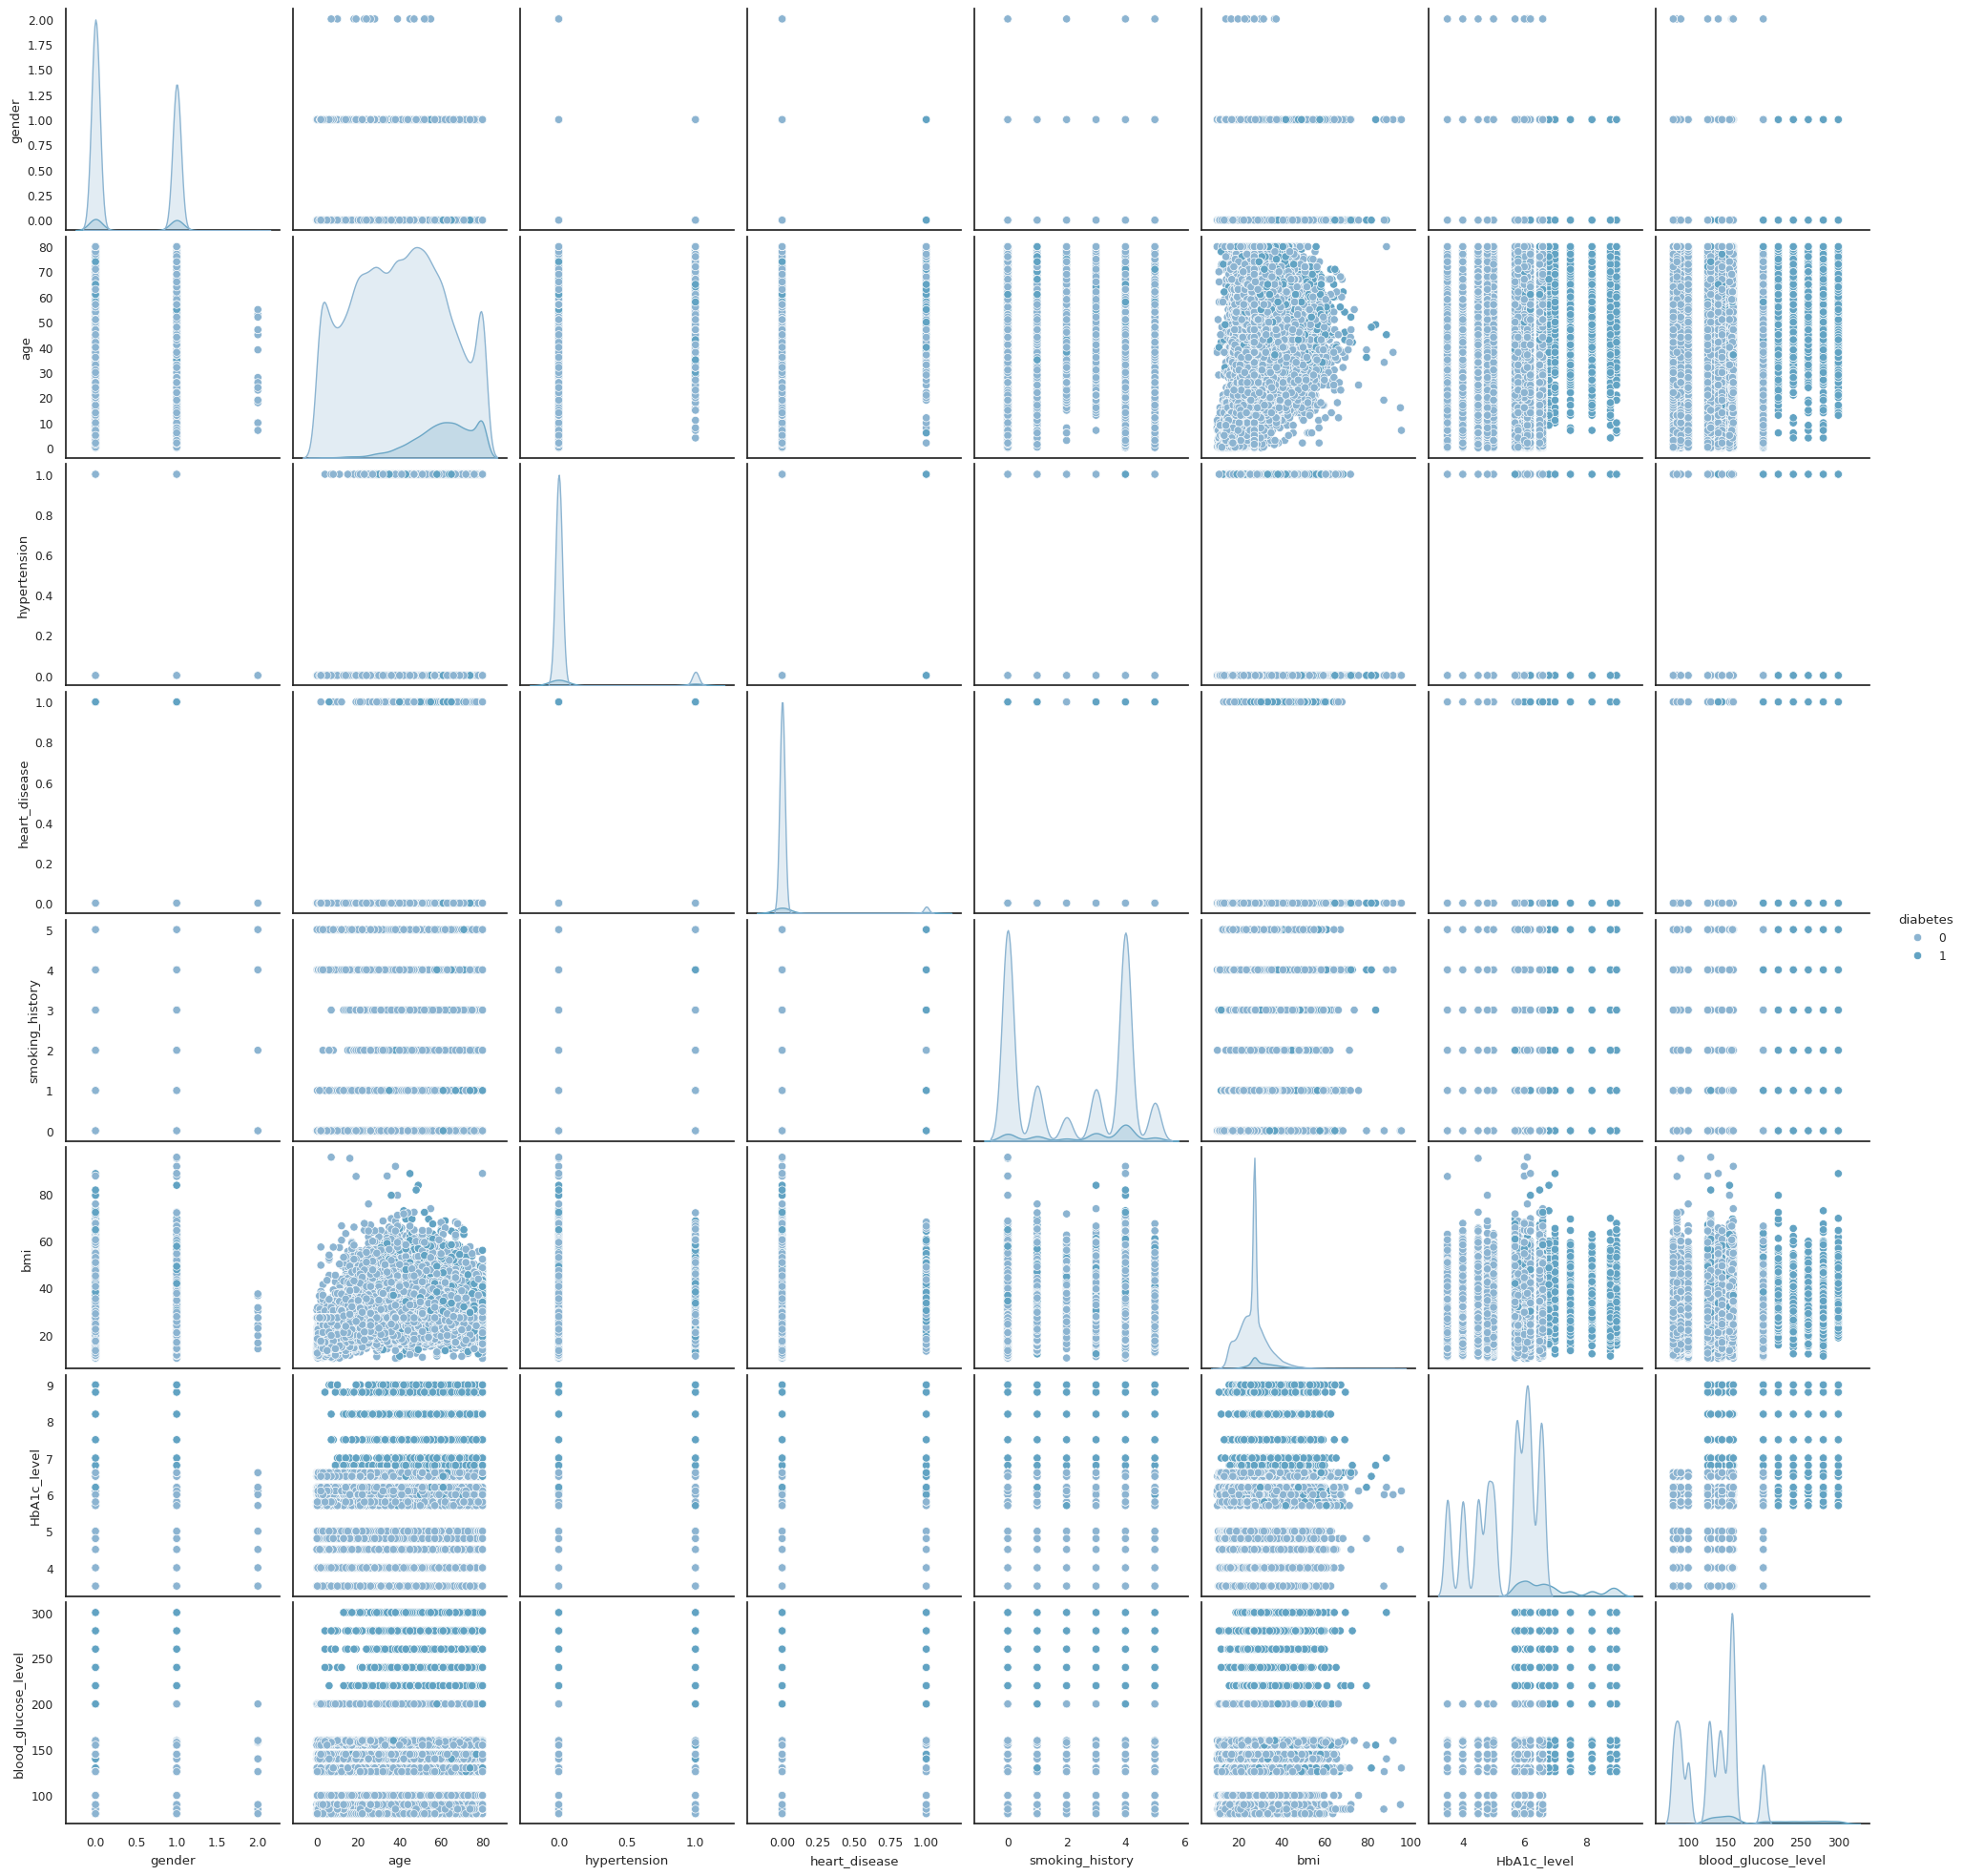

In [ ]:
# Pair plot for numeric features
sns.pairplot(diabetes_df, hue='diabetes')
plt.show()

# Detects Feature Relationships (Correlation Analysis)
# It helps identify relationships between numerical features.
# Detect redundant or highly correlated features.

# **Understanding feature types helps in deciding the type of preprocessing (scaling, encoding, etc.).**

In [ ]:
# Exploratory Data Analysis (EDA)
def eda(df, name, target_col):
    # analysis the missing values
    print("Missing values:")
    print(df.isnull().sum(), "\n")

    # analysis the duplicate values
    print("Duplicate Records:", df.duplicated().sum(), "\n")

    # Plot distribution of target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[target_col])
    plt.title(f"Distribution of Target Variable in {name}")
    plt.show()
    imbalance_ratio = df[target_col].value_counts(normalize=True).max()
    print(f"Class Imbalance Ratio: {imbalance_ratio:.2f} (max class proportion)")

    # Correlation Matrix
    # to know how strongly 2 variables are strongly related
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title(f"Feature Correlation Matrix for {name}")
    plt.show()

# **This data does not contain any missing values which shows that data is healthy for use**

# **If missing values are present in a future dataset, I will replace them with the median of the respective feature to maintain data consistency.**

In [ ]:
# Data Health Assessment
# to make high-performing model i evaluate data cleanliness, missing values, and class imbalance
def assess_data_health(df, name):
    total_missing = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    imbalance_ratio = df.iloc[:, -1].value_counts(normalize=True).max()

    print(f"\nData Health Assessment for {name}:")
    if total_missing == 0 and duplicates == 0:
        print(" - Data is clean: No missing values or duplicates.")
    else:
        if total_missing > 0:
            print(f" - {total_missing} missing values detected. Will impute with median.")
        if duplicates > 0:
            print(f" - {duplicates} duplicates detected. Consider removing if not intentional.")
    if imbalance_ratio > 0.8:
        print(" - Warning: Dataset is highly imbalanced. Consider balancing techniques.")
    else:
        print(" - Class distribution is reasonably balanced.")

assess_data_health(diabetes_df, "Diabetes Prediction Dataset")
print(diabetes_df["diabetes"].value_counts())


Data Health Assessment for Diabetes Prediction Dataset:
 - Data is clean: No missing values or duplicates.
 - Warning: Dataset is highly imbalanced. Consider balancing techniques.
diabetes
0    87664
1     8482
Name: count, dtype: int64


 **The function evaluates data cleanliness, missing values, and class imbalance before model training.**
**Checks for Missing Values, Identifies Duplicate Records, Detects Class Imbalance**

Missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64 

Duplicate Records: 0 



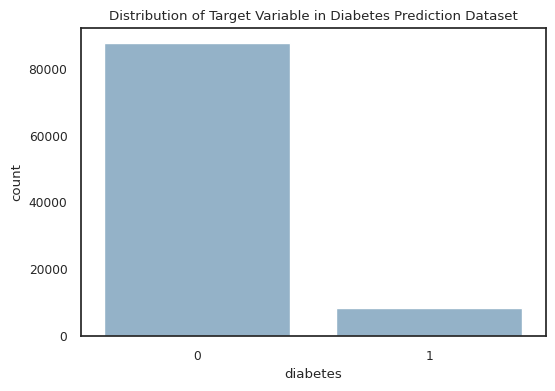

Class Imbalance Ratio: 0.91 (max class proportion)


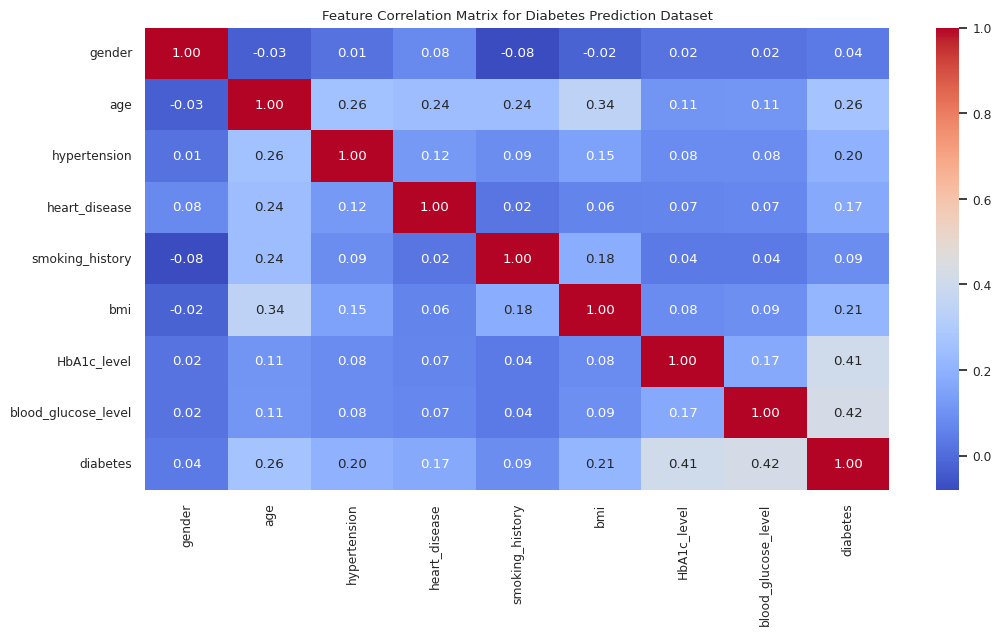

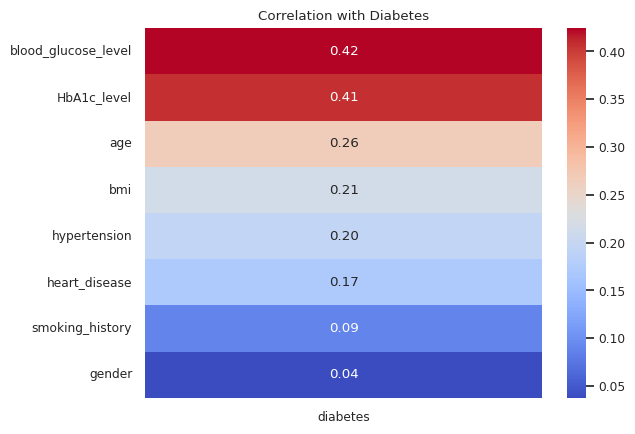

In [ ]:
# Perform EDA
eda(diabetes_df, "Diabetes Prediction Dataset", target_col_diabetes)

#Graph II
# Create a heatmap of the correlations with the target column
corr = diabetes_df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

## **Glucose level and HbA1c level are main features to predict diabetes**

# **Data Preparation: Feature Engineering,Encoding, and Scaling**


## You use SMOTE when your dataset has a class imbalance.
What’s Class Imbalance?
**Imagine a binary classification problem where:**
**Class 0 has 91.5 % of the data**
**Class 1 has only 8.5 %**
**A model trained on this will likely just predict Class 0 all the time and still get high accuracy — but it's useless for detecting the minority class.**

## **Reduce the number of samples in the majority class by removing samples randomly**

In [ ]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

Data preprocessing lays the groundwork for effective model training. In my workflow, I:
Standardize numerical features by subtracting their mean and dividing by their standard deviation—this centers them at zero with unit variance.
One‑hot encode categorical features so that algorithms can interpret them correctly.

**Standard scaler is a sciketlearn technique that centralize the data and make its variance 1**

In [ ]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = diabetes_df.drop('diabetes', axis=1)
y = diabetes_df['diabetes']

->The pipeline organizes preprocessing, resampling, and model training into one streamlined workflow, making it cleaner and more manageable.

->Oversampling (like SMOTE) and undersampling are used to balance the class distribution, which helps the model perform better on imbalanced datasets.

->A RandomForestClassifier is used as the final model for its robustness and ability to handle complex classification tasks effectively.

In [ ]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

-> A pipeline is created to organize the workflow — it first preprocesses the data and then trains a machine learning model.

-> The model used is a RandomForestClassifier, a robust and widely-used algorithm that works well for many classification problems by building multiple decision trees and combining their results.

-> To improve the model’s performance, we use GridSearchCV from sklearn.model_selection, which:

-> Performs an exhaustive search through a grid of different combinations of hyperparameters (like number of trees, depth, etc.).

In [ ]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


Converts **GridSearchCV** results into a DataFrame to simplify the analysis and make it easier to visualize hyperparameter tuning outcomes.

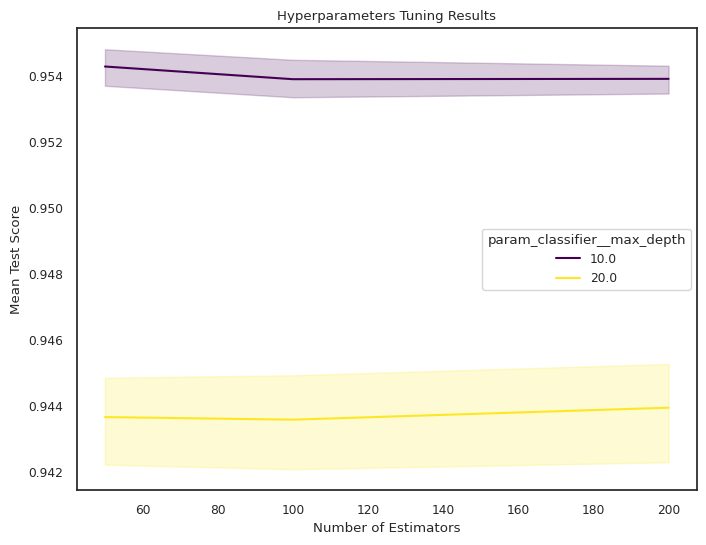

In [ ]:
# Convert GridSearchCV results to a DataFrame and plot
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

# The trained model is evaluated on the test set. Confusion matrix is used to visualize the performance of the model. It shows the true positive, true negative, false positive, and false negative predictions of the model.

# i have calculated **model accuracy** on the basis of prediction of test data and also calculated precision,recall and F1 score

Model Accuracy:  0.9533541341653666
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17509
           1       0.71      0.80      0.75      1721

    accuracy                           0.95     19230
   macro avg       0.85      0.89      0.86     19230
weighted avg       0.96      0.95      0.95     19230



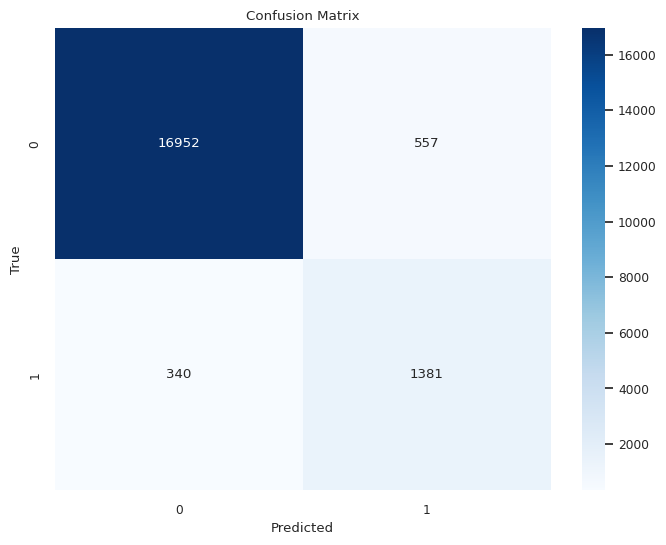

In [ ]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

my model accuracy through random forest classifier model is **95.38 %**.

Now i am calculating features importance after model fitting:

The feature importance gives insight into which features are most useful for making predictions

                Feature  Importance
2           HbA1c_level    0.415017
3   blood_glucose_level    0.307296
0                   age    0.126970
1                   BMI    0.065289
4          hypertension    0.040965
5         heart_disease    0.019632
9     smoking_history_0    0.011333
12    smoking_history_3    0.006434
7              gender_1    0.001997
6              gender_0    0.001741
13    smoking_history_4    0.001213
10    smoking_history_1    0.000789
11    smoking_history_2    0.000693
14    smoking_history_5    0.000630
8              gender_2    0.000001


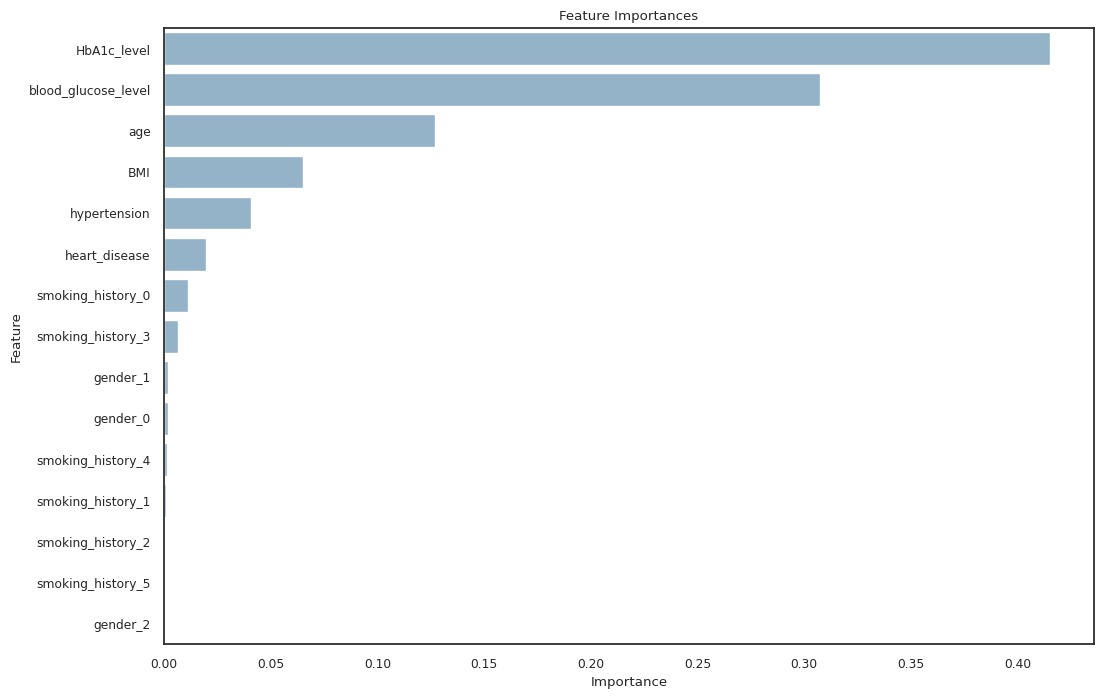

In [ ]:
# After fitting the model, we input feature names
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

# And now let's get the feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

 XGBoost uses boosting, where trees are built sequentially to correct errors, often leading to better accuracy compared to Random Forest's bagging approach.

XGBoost incorporates regularization, reducing the risk of overfitting and improving model generalization, while Random Forest may still overfit with deep trees.

XGBoost is typically faster and more efficient, especially on large datasets, due to its optimized training and parallel computation.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model to your training data
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test,y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9699427977119085

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.96      0.69      0.81      1721

    accuracy                           0.97     19230
   macro avg       0.96      0.85      0.89     19230
weighted avg       0.97      0.97      0.97     19230


Confusion Matrix:
 [[17457    52]
 [  526  1195]]


# **Inference:**
 Class 1 (Minority Class) is Underserved
Recall (Class 1) = 0.69:

The model fails to detect 31% of actual Class 1 instances. This is critical if Class 1 represents important cases like fraud, failure, or disease.

Precision (Class 1) = 0.96:

When the model predicts Class 1, it's very likely to be correct.

Trade-off: The model is cautious about predicting Class 1, which keeps precision high but hurts recall.

1. High Accuracy Can Be Misleading
Accuracy: 96.99% is impressive at face value, but:
there is highle class imbalance which may mislead the model.
A model predicting only Class 0 would still get ~91% accuracy — accuracy isn't enough in imbalanced datasets.

# i got better accuracy(**96.99 %**) from XGboost than Random forest classifier model

# **Model Conclusion**
## **High Overall Accuracy**: The XGBoost classifier achieved a strong overall accuracy of 96.99%, indicating reliable performance across the dataset.